In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

from netam import framework, models
from epam.torch_common import pick_device, parameter_count_of_model

/Users/matsen/mambaforge/envs/epam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from netam.framework import load_shmoof_dataframes

shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"
val_nicknames = ['59', '88', '97', 'small']

max_length=410
batch_size=1024
device = pick_device()

def data_of_nickname(nickname, kmer_length):
    train_df, val_df = load_shmoof_dataframes(shmoof_path, val_nickname=nickname) #, sample_count=1000)
    train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
    val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)
    return train_dataset, val_dataset

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Using Metal Performance Shaders


In [3]:
burrito_params = {
    "batch_size": 1024,
    "learning_rate": 0.1,
    "min_learning_rate": 1e-4,
    "l2_regularization_coeff": 1e-6
}
epochs = 100

In [4]:
def train_and_evaluate(model_name, model_instance, train_dataset, val_dataset):
    print(f"\tTraining {model_name}...")
    if "cnn" in model_name:
        train_dataset.to(device)
        val_dataset.to(device)
        model_instance.to(device)
    burrito = framework.Burrito(train_dataset, val_dataset, model_instance, verbose=False, **burrito_params)
    
    train_history = burrito.train(epochs=epochs)
    # final_train_loss = burrito.process_data_loader(train_loader)
    best_val_loss = train_history['val_loss'].min()

    # Record pre-training and post-training losses
    result = {'model name': model_name, 'model': str(model_instance), 'parameter count': parameter_count_of_model(model_instance), 'val_loss': best_val_loss}
    return result

def comparison_of_data(model_instances, train_dataset, val_dataset):
    results_list = []

    for model_name, model_instance in model_instances.items():
        result = train_and_evaluate(model_name, model_instance, train_dataset, val_dataset)
        results_list.append(result)

    results_df = pd.DataFrame(results_list)
    return results_df

comparison_dfs = []
for nickname in val_nicknames:
    print(f"Val nickname is {nickname}")
    train_dataset_3, val_dataset_3 = data_of_nickname(nickname, kmer_length=3)
    train_dataset_5, val_dataset_5 = data_of_nickname(nickname, kmer_length=5)
    
    model_instances_3 = {
        # "cnn_sml_drop00": models.CNNModel(train_dataset_3, embedding_dim=8, num_filters=8, kernel_size=5, dropout_rate=0.0),
        # "cnn_sml_drop02": models.CNNModel(train_dataset_3, embedding_dim=8, num_filters=8, kernel_size=5, dropout_rate=0.2),
        # "cnn_sml_drop04": models.CNNModel(train_dataset_3, embedding_dim=8, num_filters=8, kernel_size=5, dropout_rate=0.4),
        "cnn_med_drop00": models.CNNModel(train_dataset_3, embedding_dim=12, num_filters=13, kernel_size=7, dropout_rate=0.0),
        "cnn_med_drop02": models.CNNModel(train_dataset_3, embedding_dim=12, num_filters=13, kernel_size=7, dropout_rate=0.2),
        "cnn_med_drop04": models.CNNModel(train_dataset_3, embedding_dim=12, num_filters=13, kernel_size=7, dropout_rate=0.4),
        # "cnn_big_drop00": models.CNNModel(train_dataset_3, embedding_dim=21, num_filters=13, kernel_size=13, dropout_rate=0.0),
        # "cnn_big_drop02": models.CNNModel(train_dataset_3, embedding_dim=21, num_filters=13, kernel_size=13, dropout_rate=0.2),
        # "cnn_big_drop04": models.CNNModel(train_dataset_3, embedding_dim=21, num_filters=13, kernel_size=13, dropout_rate=0.4),
    }

    model_instances_5 = {
        "fivemer": models.FivemerModel(train_dataset_5),
        "shmoof": models.SHMoofModel(train_dataset_5),
    }
     
    comparison_df = \
        pd.concat([comparison_of_data(model_instances_3, train_dataset_3, val_dataset_3),
                    comparison_of_data(model_instances_5, train_dataset_5, val_dataset_5)])
    comparison_df["val_nickname"] = nickname

    # make val_nickname the first column
    cols = comparison_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    comparison_df = comparison_df[cols]

    comparison_dfs.append(comparison_df)

final_df = pd.concat(comparison_dfs)
final_df.to_csv(f"_ignore/model_comparison_{framework.timestamp_str()}.csv", index=False)
final_df
    

Val nickname is 59
	Training cnn_med_drop00...
	Training cnn_med_drop02...
	Training cnn_med_drop04...
	Training fivemer...
	Training shmoof...
Val nickname is 88
	Training cnn_med_drop00...
	Training cnn_med_drop02...


KeyboardInterrupt: 

In [ ]:
final_df.to_clipboard()


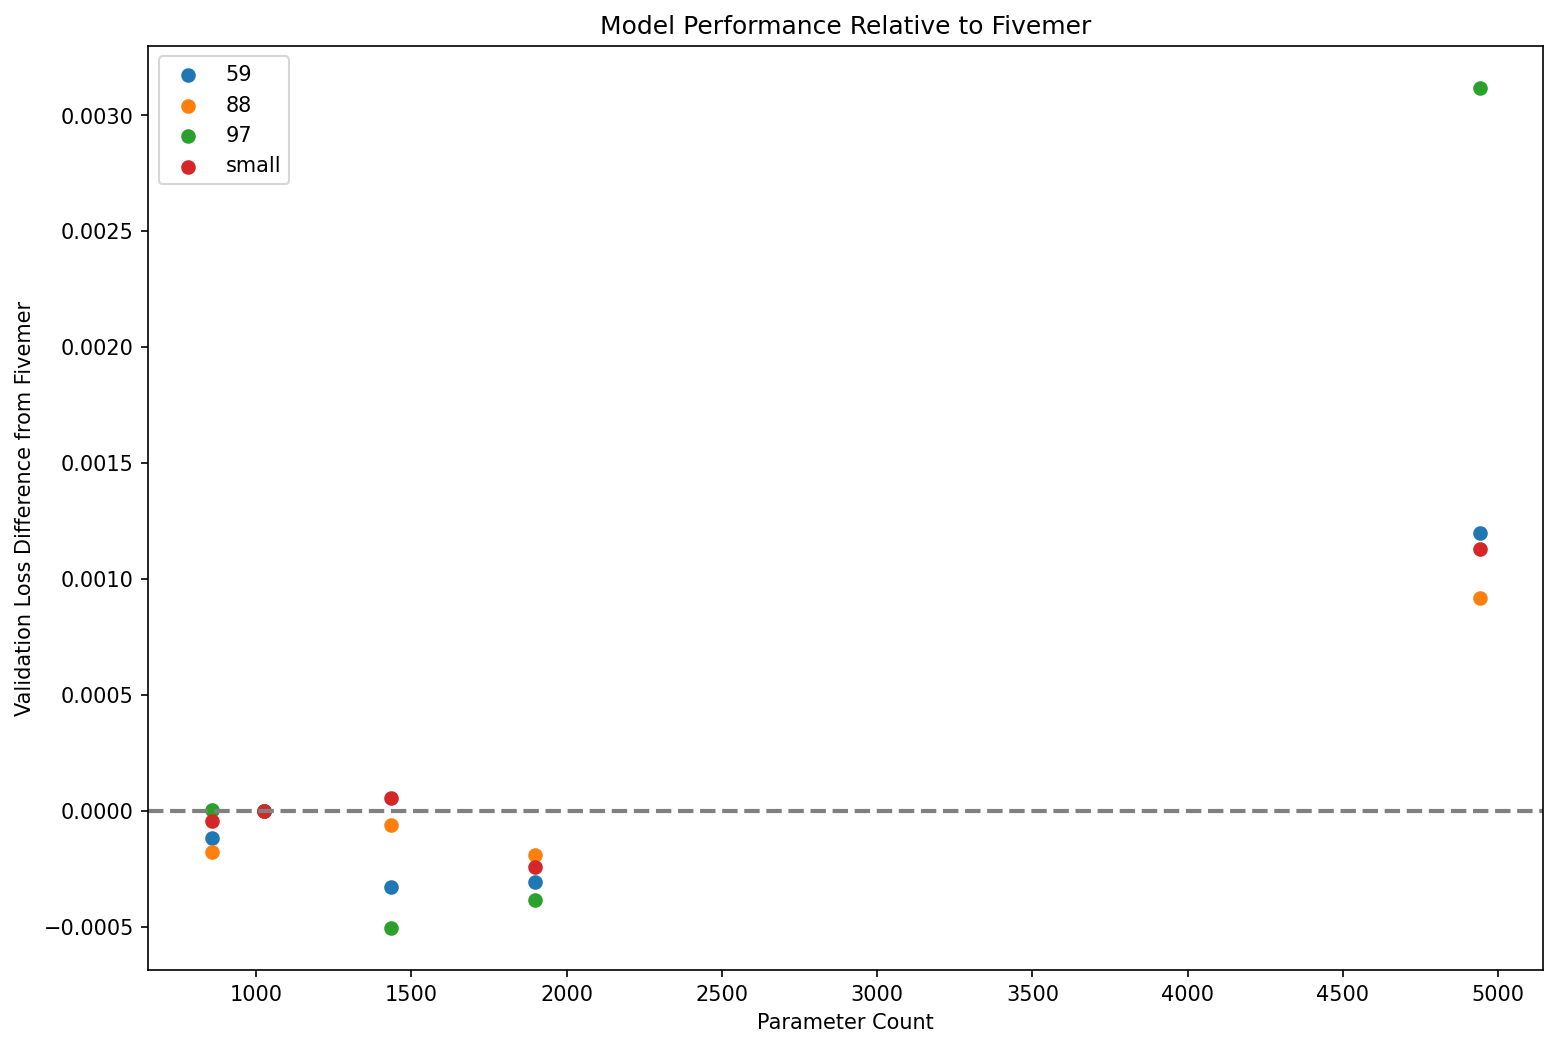

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

#df = final_df
df = pd.read_csv("/Users/matsen/re/netam/notebooks/_ignore/model_comparison_20231122_072627.csv")

# Calculate the difference in validation loss from the fivemer model
loss_diffs = []
for nickname in df['val_nickname'].unique():
    fivemer_loss = df[(df['model name'] == 'fivemer') & (df['val_nickname'] == nickname)]['val_loss'].values[0]
    for _, row in df[df['val_nickname'] == nickname].iterrows():
        if row['model'] != 'fivemer':
            diff = row['val_loss'] - fivemer_loss
            loss_diffs.append({'val_nickname': nickname, 'model': row['model name'], 'parameter_count': row['parameter count'], 'loss_diff': diff})

# Convert to DataFrame
loss_diff_df = pd.DataFrame(loss_diffs)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for nickname in loss_diff_df['val_nickname'].unique():
    subset = loss_diff_df[loss_diff_df['val_nickname'] == nickname]
    ax.scatter(subset['parameter_count'], subset['loss_diff'], label=nickname)

ax.set_xlabel('Parameter Count')
ax.set_ylabel('Validation Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.axhline(0, color='grey', lw=2, linestyle='--')
ax.legend()
plt.show()


In [15]:
df["parameter count"].unique()
df.loc[df["parameter count"]==857]

,val_nickname,model name,model,parameter count,val_loss
0,59,cnn_sml_drop04,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",857,0.058279
5,88,cnn_sml_drop04,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",857,0.050537
10,97,cnn_sml_drop04,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",857,0.055366
15,small,cnn_sml_drop04,"CNNModel(\n (kmer_embedding): Embedding(65, 8...",857,0.055706


In [13]:
df[(df['model name'] == 'fivemer')]

,val_nickname,model name,model,parameter count,val_loss
3,59,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.058399
8,88,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.050714
13,97,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.055363
18,small,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.055749


In [ ]:
# Set the aesthetics for the plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Scatter plot with direct labeling
for index, row in results_df.iterrows():
    plt.scatter(row['train_loss'], row['val_loss'], label=row['model'], s=100)
    plt.text(row['train_loss'], row['val_loss'], row['model'], fontsize=9)

if False:
    # # Plot x=y line
    max_loss = max(results_df['train_loss'].max(), results_df['val_loss'].max())
    min_loss = min(results_df['train_loss'].min(), results_df['val_loss'].min())
    plt.plot([min_loss, max_loss],
            [min_loss, max_loss],
            'k--', lw=1, label='x = y')

# Adding additional details to the plot
plt.title('Comparison of Training and Validation Losses for Trained Models')
plt.xlabel('Training Loss')
plt.ylabel('Validation Loss')
# plt.legend(title='Reference')
plt.grid(True)
plt.tight_layout()

plt.show()

NameError: name 'results_df' is not defined

<Figure size 1200x900 with 0 Axes>